In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.dft import *


import matplotlib.pyplot as plt

In [2]:
feos_pcsaft.__file__

'/home/bursik/anaconda3/envs/conda_pcsaft/lib/python3.10/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

# Local DFT Implementation

In [11]:
components = ['hexane']#, 'pentane']
composition = np.array([0.3, 0.7]) *MOL
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [12]:
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')
func = PcSaftFunctional(params)
func_hs = (params)

In [13]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)

In [14]:
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 60 * ANGSTROM, t_crit)

In [15]:
interface.local_functional_derivative

array([[ 4.25951282,  4.25951249,  4.25951212, ..., 25.11069765,
        25.11072045, 25.11074143]])

In [16]:
# solve DFT
interface.solve(solver)

In [17]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.weighted_densities)[0][4,:])
plt.plot(interface.z / ANGSTROM, (interface.local_weighted_densities)[0][4,:])


IndexError: index 4 is out of bounds for axis 0 with size 3

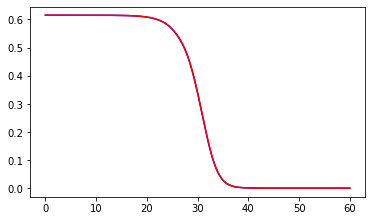

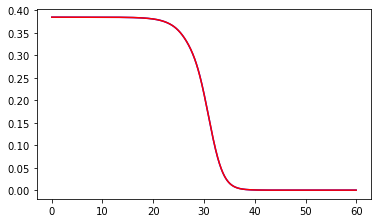

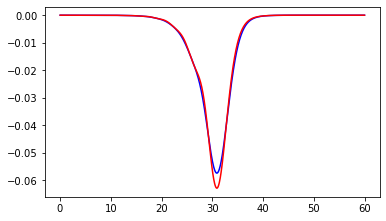

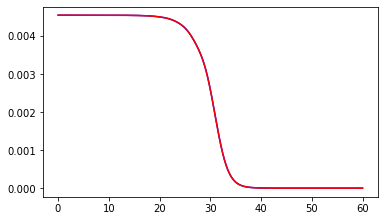

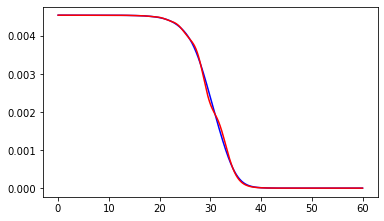

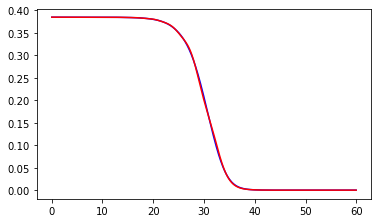

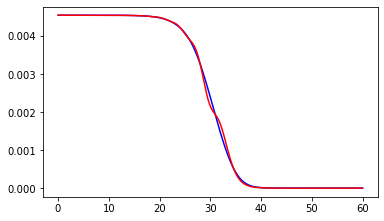

In [18]:
# plot initial density profile
i = 0
for wds, lwds in zip(interface.weighted_densities, interface.local_weighted_densities):
    for wd, lwd in zip(wds, lwds):
        
        plt.figure(figsize=(6,3.5))
        plt.plot(interface.z / ANGSTROM, wd, 'b')
        plt.plot(interface.z / ANGSTROM, lwd, 'r')
        #plt.savefig(f'weighted_density_{i}.pdf', )  
        i = i+1
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

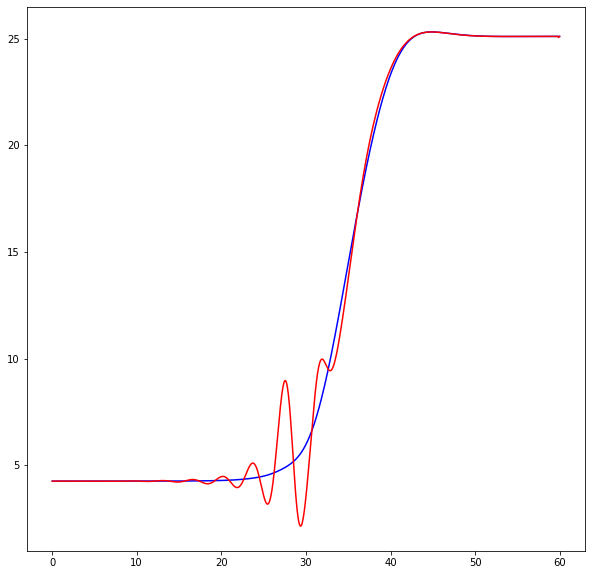

In [19]:
# plot initial density profile
i=0
for fd, lfd in zip(interface.functional_derivative, interface.local_functional_derivative):
    plt.figure(figsize=(10,10))
    plt.plot(interface.z / ANGSTROM, fd, 'b')
    plt.plot(interface.z / ANGSTROM, lfd, 'r')
    
    #plt.savefig(f'functional_derivative_{i}.pdf', )  
    i=i+1
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [11]:
wd = interface.weighted_densities
plt.plot(interface.z / ANGSTROM, (wd / MOL * METER**3)[0,:])
print(len(wd))
print(wd[1].shape)

TypeError: not implemented!

## DFT Example

In [10]:
## Planar Interface 

In [11]:
# system specification
components = ['hexane', 'octane'] # ['hexane'] # 
x = 0.3
composition = np.array([x, 1-x])
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [12]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [13]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [14]:
# calculate phase equilibrium
#vle = PhaseEquilibrium.pure_t(func, temperature)
vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition)
vle


||temperature|density|molefracs|
|-|-|-|-|
|phase 1|298.15 K|2.964357865432749  mol/m³|[0.81911, 0.18089]|
|phase 2|298.15 K|6.446506873296946 kmol/m³|[0.30000, 0.70000]|


In [15]:
# calculate critical point (needed for initializiation of tanh profile)
#t_crit = State.critical_point_pure(func)[0].temperature
t_crit = State.critical_point(func, 1 * MOL *composition).temperature
t_crit

568.0769398960161 K

In [16]:
# intialize solver and interface density profile
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

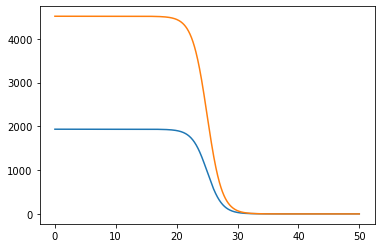

In [17]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [18]:
# solve DFT
interface.solve(solver)

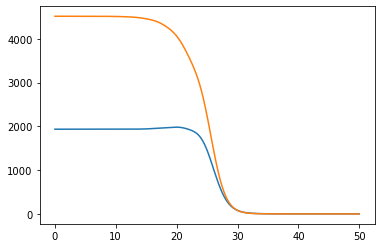

In [19]:
# plot final density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [20]:
# print surface tension
interface.surface_tension

20.13926529391086 mN/m

In [21]:
interface.equimolar_radius

2.4999964243533226 nm

# Adsorption at a wall in 1D

In [21]:
# system specification
components =  ['butane', 'pentane']
x = 0.5
composition = np.array([x, 1-x])
temperature = 250.15* KELVIN
pressure = 1 * BAR

In [22]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [23]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [24]:
# Create State 
state = State(func, temperature, pressure=pressure, molefracs=composition)

In [25]:
# create potential 
potential  = ExternalPotential.LJ93(3.0, 150.0, 0.08)
#potential  = ExternalPotential.HardWall(3.1)


In [26]:
#np.array([[5,5]*ANGSTROM,[10,10]*ANGSTROM])

In [37]:
# Create wall as a cartesian (slit) pore with large width --> bulk in the center
wall_profile = Pore1D(func, Geometry.Cartesian, 30*ANGSTROM, potential, 512).initialize(state)

In [38]:
(wall_profile.density/MOL*METER**3)[0]

array([4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
       4.91646755e+03, 4.91646755e+03, 4.91646755e+03, 4.91646755e+03,
      

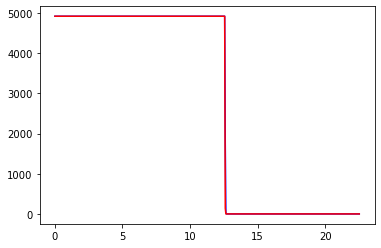

In [39]:
plt.plot(wall_profile.z / ANGSTROM,(wall_profile.density/MOL * METER **3)[0,:], 'b')
plt.plot(wall_profile.z / ANGSTROM, (wall_profile.density/MOL * METER **3)[1,:], 'r')

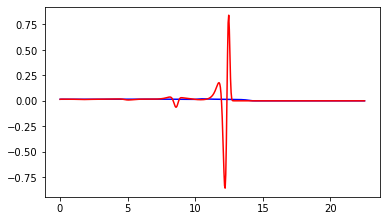

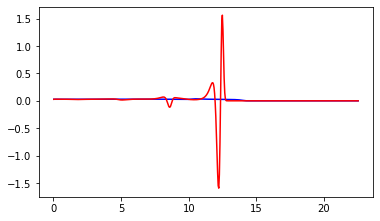

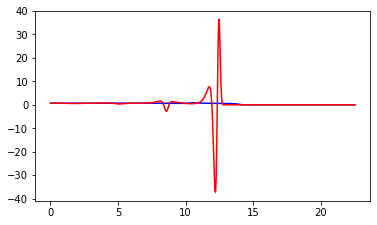

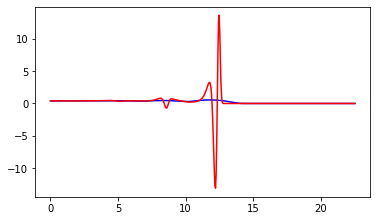

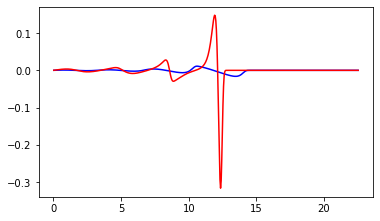

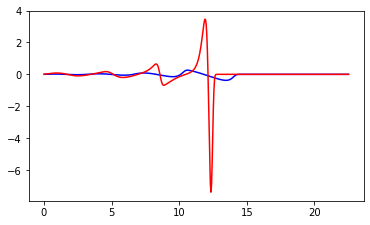

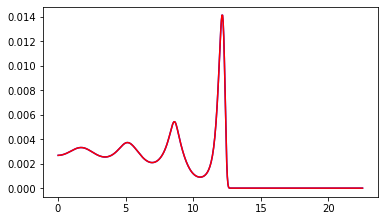

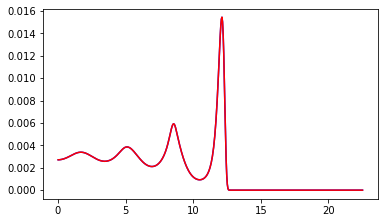

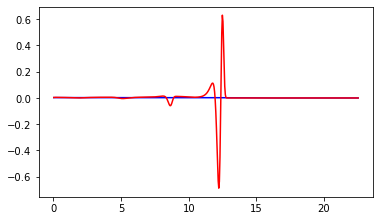

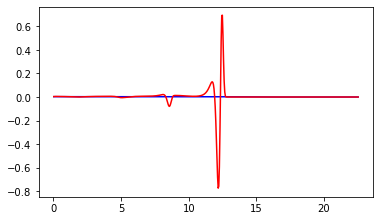

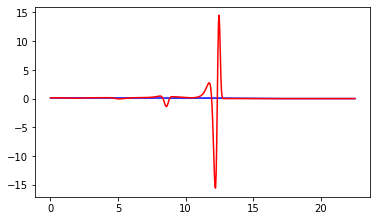

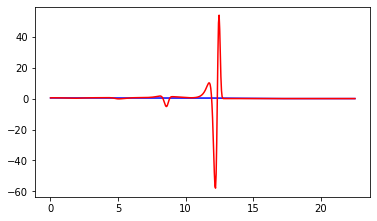

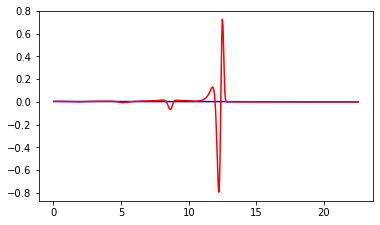

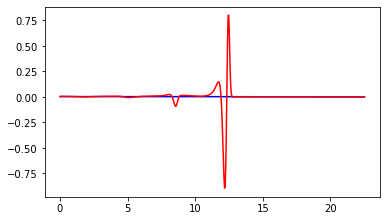

In [44]:
# plot initial density profile
i = 0
for wds, lwds in zip(wall_profile.weighted_densities, wall_profile.local_weighted_densities):
    for wd, lwd in zip(wds, lwds):
        
        plt.figure(figsize=(6,3.5))
        plt.plot(wall_profile.z / ANGSTROM, wd, 'b')
        plt.plot(wall_profile.z / ANGSTROM, lwd, 'r')
       # plt.savefig(f'weighted_density_{i}.pdf', )  
        i = i+1
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

og domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain error

log domain 

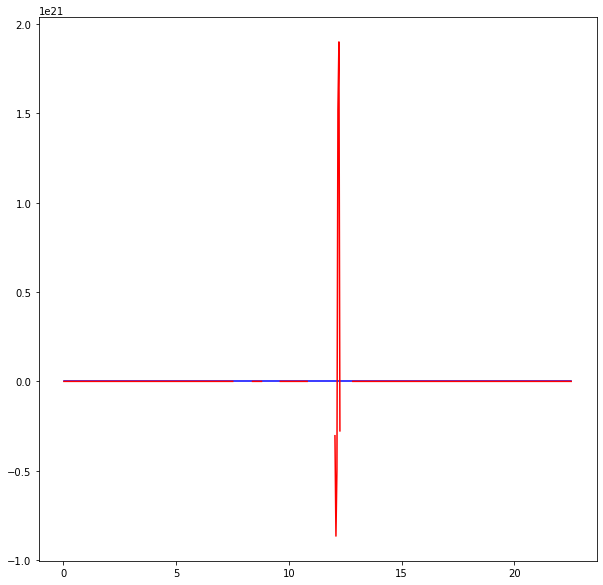

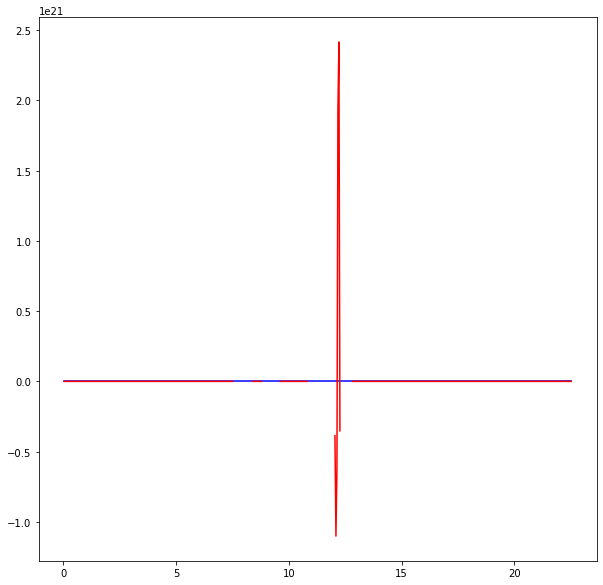

In [46]:
# plot initial density profile
i=0
for fd, lfd in zip(wall_profile.functional_derivative, wall_profile.local_functional_derivative):
    plt.figure(figsize=(10,10))
    plt.plot(wall_profile.z / ANGSTROM, fd, 'b')
    plt.plot(wall_profile.z / ANGSTROM, lfd, 'r')
    
    plt.savefig(f'functional_derivative_{i}.pdf', )  
    i=i+1
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [42]:
# set solver
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-6, max_iter=100).anderson_mixing(tol=1.0e-8, max_iter=500, mmax=10)

In [43]:
# solve DFT for wall 
wall_profile.solve(solver)

solver               | iter | residual 


-------------------------------------------
Picard iteration     |    1 | 1.900411e-2 | 0.00000000000024602814176214287
Picard iteration     |    2 | 1.831382e-3 | 0.000000000004274750352979447
Picard iteration     |    3 | 4.250307e-3 | 0.000000000002233979575564898
Picard iteration     |    4 | 2.481974e-3 | 0.00000000008653019396556737
Picard iteration     |    5 | 2.927275e-3 | 0.000000000013387153513127371
Picard iteration     |    6 | 2.249968e-3 | 0.0000000002470323535447917
Picard iteration     |    7 | 3.635263e-3 | 0.00000000005335159871865686
Picard iteration     |    8 | 2.721452e-3 | 0.000000006432285804892277
Picard iteration     |    9 | 1.793618e-3 | 0.0000000003494042624676802
Picard iteration     |   10 | 1.789260e-3 | 0.000000001916277370344785
Picard iteration     |   11 | 3.448593e-3 | 0.0000000009298832337076369
Picard iteration     |   12 | 2.809227e-3 | 0.000000140211392310385
Picard iteration     |   13 | 1.738614e-3 | 0.000000006037388651979385
Picard iteratio

In [ ]:
# plot resulting density profile
plt.plot(wall_profile.z/ANGSTROM, (wall_profile.density/MOL*METER**3)[0,:])

In [ ]:
wall_profile.density/MOL*METER**3